<a href="https://colab.research.google.com/github/rayen03/Brain-Tumor-segmentation/blob/main/MIT_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Env setup**


In [1]:

!pip install -q kaggle
! mkdir ~/.kaggle
# API key
from google.colab import files
files.upload()  #  kaggle.json
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download awsaf49/brats20-dataset-training-validation



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [00:45<00:00, 56.3MB/s]
100% 4.16G/4.16G [00:45<00:00, 97.7MB/s]


In [2]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
import zipfile
from sklearn.model_selection import train_test_split, KFold


In [3]:
zip_path = "/content/brats20-dataset-training-validation.zip"
train_dataset_path = "/content/BraTS2020_TrainingData"
val_dataset_path = "/content/BraTS2020_ValidationData"

if not os.path.exists(train_dataset_path) or not os.path.exists(val_dataset_path):
    print(f" Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content")
    print(" Extraction complete")
else:
    print("Dataset already extracted")

 Extracting /content/brats20-dataset-training-validation.zip ...
 Extraction complete


In [ ]:
#unzip data method 2
! unzip brats20-dataset-training-validation.zip

Archive:  brats20-dataset-training-validation.zip
replace BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Loading test data

In [4]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
test_image_t1 = nib.load(TRAIN_DATASET_PATH + '/BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + '/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + '/BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_image_flair = nib.load(TRAIN_DATASET_PATH +"/BraTS20_Training_001/BraTS20_Training_001_flair.nii").get_fdata()
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)


Shape:  (240, 240, 155)
Dtype:  float64


MinMax resclaing

In [5]:
scaler = MinMaxScaler()
#Rescaling t1
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

#Rescaling flair
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

# **Data visualisation**

MultiModal Plots

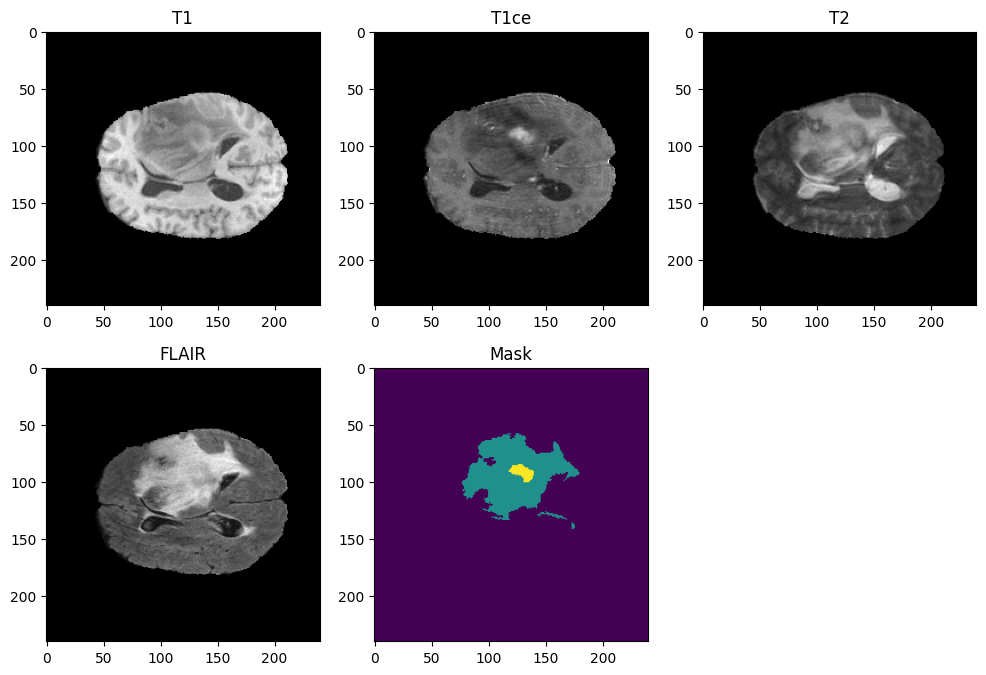

In [ ]:

slice=80
plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

Multi dimensional T1 and segmentaion

Slice number: 80


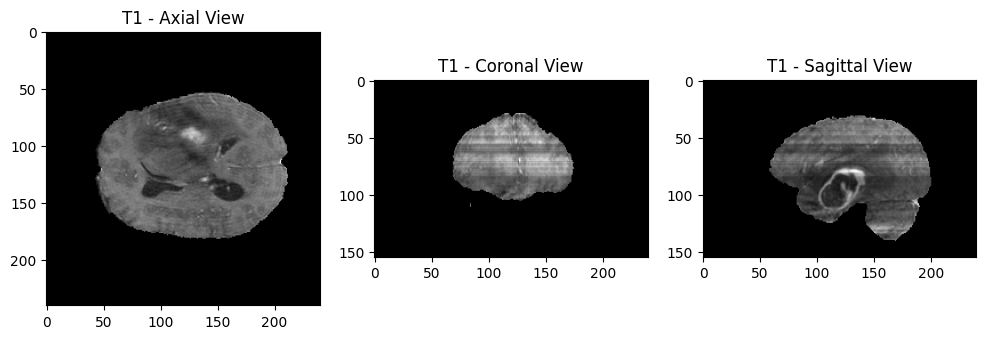

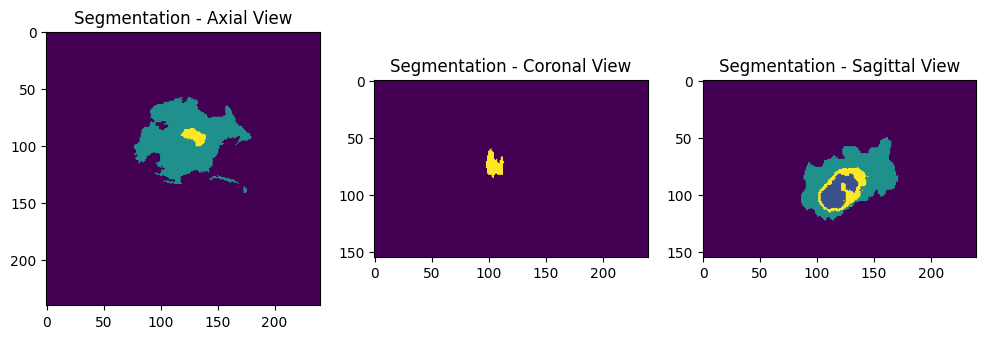

In [ ]:
slice = 80

print("Slice number: " + str(slice))
#t1ce slices
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Axial View')


plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Coronal View')


plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()
#------------------------------------
#segmentation slices
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Segmentation - Axial View')

plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_seg[:,slice,:], 90, resize=True))
plt.title('Segmentation - Coronal View')

plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_seg[slice,:,:], 90, resize=True))
plt.title('Segmentation - Sagittal View')
plt.show()

Slices distribution

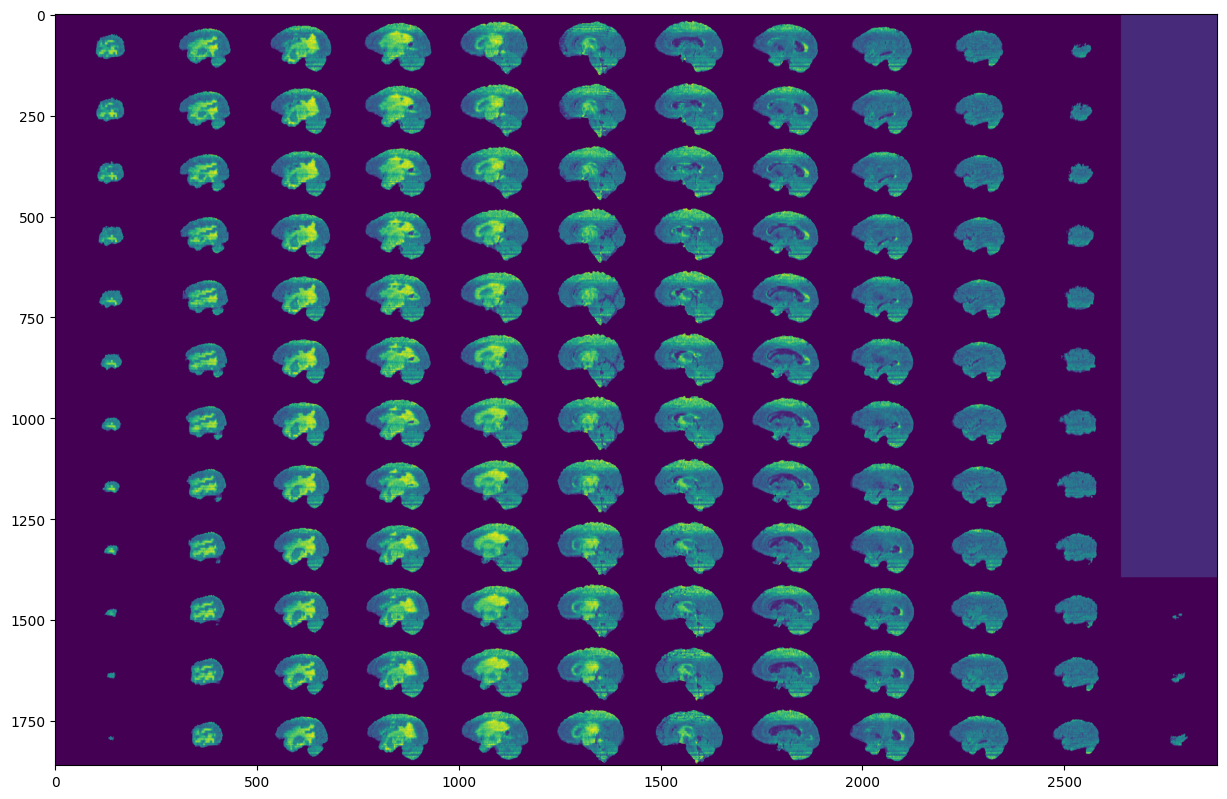

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_flair[50:-55,:,:]), 90, resize=True));

Segmentation distribution


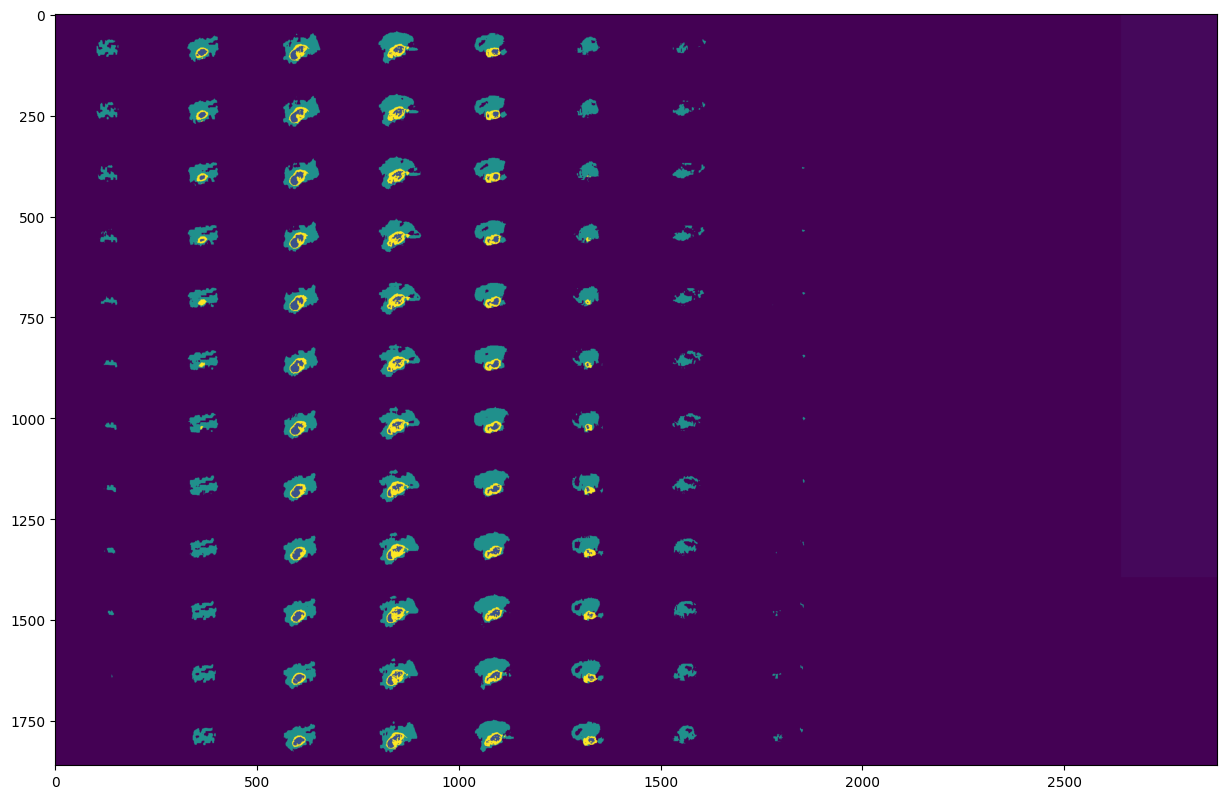

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 1, 1)

plt.imshow(rotate(montage(test_image_seg[50:-55,:,:]), 90, resize=True));

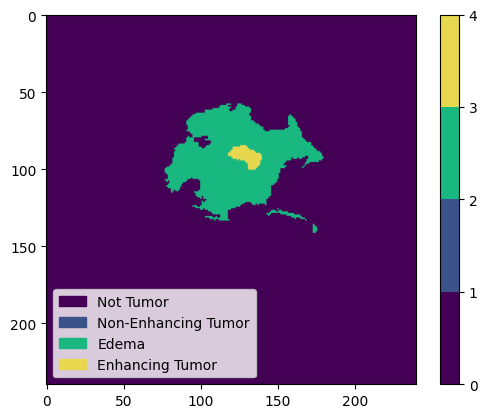

In [ ]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([0, 1, 2, 3, 4], cmap.N)


plt.imshow(test_image_seg[:,:,slice], cmap=cmap, norm=norm)
plt.colorbar()
class_names = ['Not Tumor', 'Non-Enhancing Tumor', 'Edema', 'Enhancing Tumor']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=legend, loc='lower left')
plt.show()

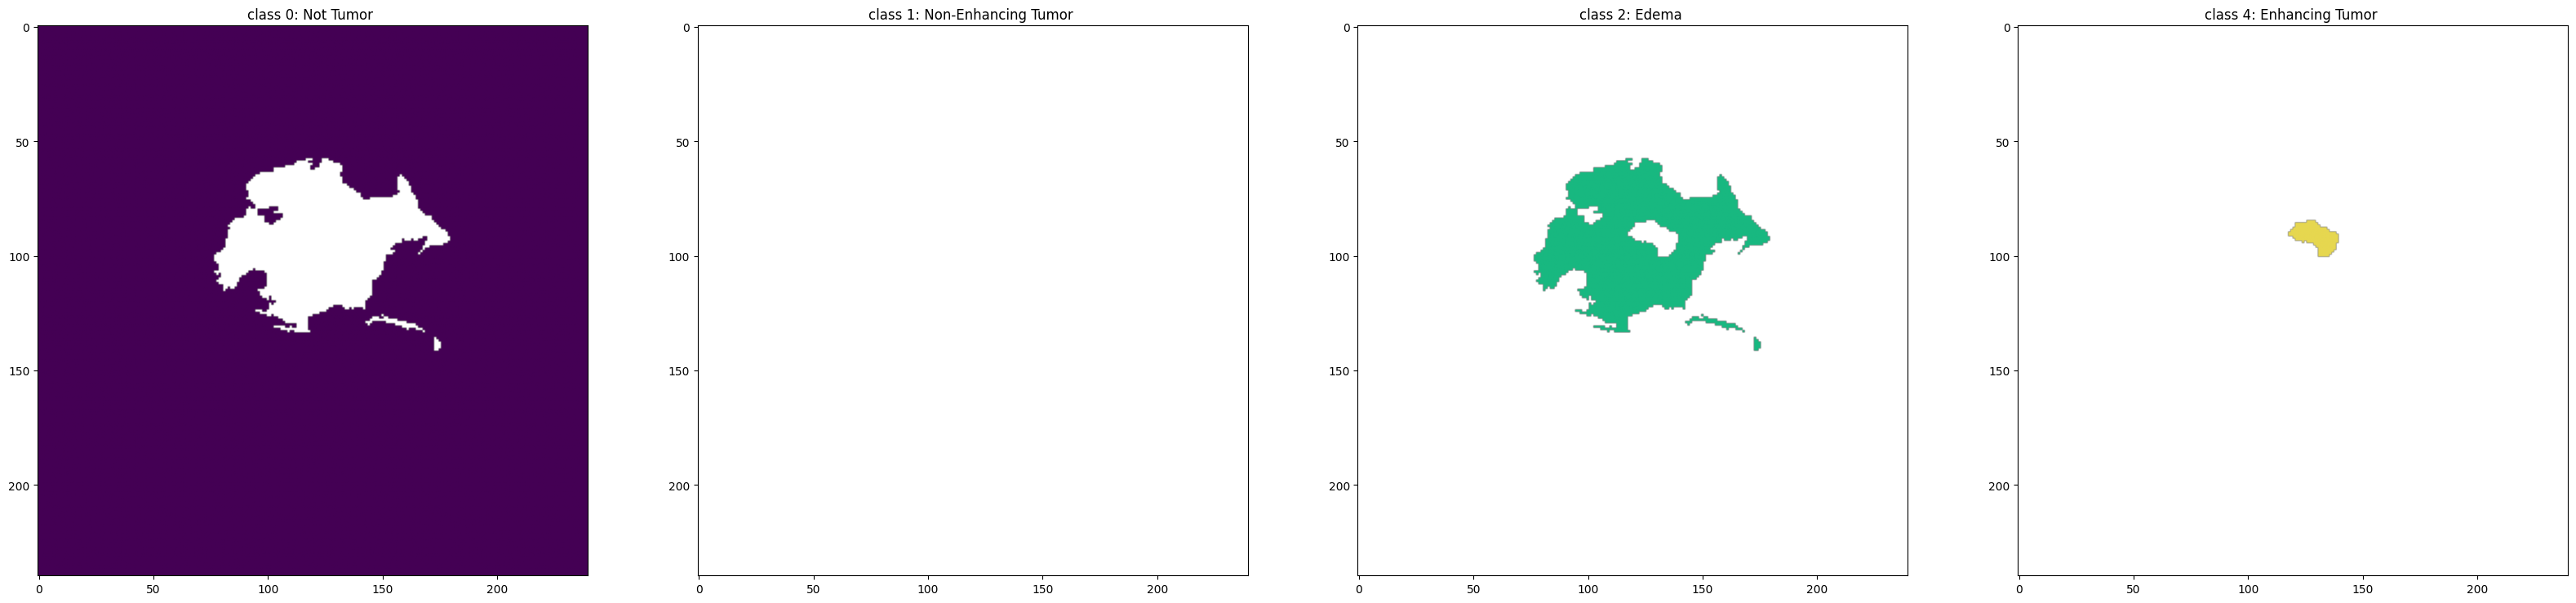

In [ ]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan
fig, ax = plt.subplots(1, 4, figsize=(40, 40))


ax[0].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('class 0: Not Tumor ')

ax[1].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('class 1: Non-Enhancing Tumor ')

ax[2].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('class 2: Edema ')

ax[3].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('class 4: Enhancing Tumor ')

plt.show()

# **Dataset split**

In [6]:

random_state = 42
case_ids = [d for d in os.listdir(TRAIN_DATASET_PATH) if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))]
total_cases = len(case_ids)
print("Total cases:", total_cases)


train_val_ids, test_ids = train_test_split(
    case_ids, test_size=0.10, random_state=random_state
)

train_ids, val_ids = train_test_split(
    train_val_ids, test_size=0.222, random_state=random_state
)


print(f"\n Fixed Split Results:")
print(f"Train: {len(train_ids)} ({len(train_ids)/total_cases*100:.2f}%)")
print(f"Val:   {len(val_ids)} ({len(val_ids)/total_cases*100:.2f}%)")
print(f"Test:  {len(test_ids)} ({len(test_ids)/total_cases*100:.2f}%)")

# Save split
df_split = pd.DataFrame({
    "case_id": train_ids + val_ids + test_ids,
    "split": ["train"]*len(train_ids) + ["val"]*len(val_ids) + ["test"]*len(test_ids)
})
df_split.to_csv("brats2020_split_fixed.csv", index=False)
print("\n Fixed split saved to brats2020_split_fixed.csv")


#K-Fold Cross Validation

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=random_state)

folds = []
for fold, (train_idx, val_idx) in enumerate(kf.split(case_ids)):
    train_cases = [case_ids[i] for i in train_idx]
    val_cases = [case_ids[i] for i in val_idx]

    folds.extend([(cid, fold, "train") for cid in train_cases])
    folds.extend([(cid, fold, "val") for cid in val_cases])

df_folds = pd.DataFrame(folds, columns=["case_id", "fold", "split"])
df_folds.to_csv("brats2020_kfolds.csv", index=False)

print(f"\n {K}-fold cross-validation splits saved to brats2020_kfolds.csv")


Total cases: 369

 Fixed Split Results:
Train: 258 (69.92%)
Val:   74 (20.05%)
Test:  37 (10.03%)

 Fixed split saved to brats2020_split_fixed.csv

 5-fold cross-validation splits saved to brats2020_kfolds.csv


In [7]:

# Load the fixed split CSV
df_split = pd.read_csv("brats2020_split_fixed.csv")
print("Head:")
print(df_split.head(20))
print("\n Split distribution:")
print(df_split["split"].value_counts())
print("\n Split percentages:")
print(df_split["split"].value_counts(normalize=True) * 100)


Head:
                 case_id  split
0   BraTS20_Training_326  train
1   BraTS20_Training_186  train
2   BraTS20_Training_255  train
3   BraTS20_Training_148  train
4   BraTS20_Training_085  train
5   BraTS20_Training_209  train
6   BraTS20_Training_259  train
7   BraTS20_Training_243  train
8   BraTS20_Training_019  train
9   BraTS20_Training_128  train
10  BraTS20_Training_187  train
11  BraTS20_Training_029  train
12  BraTS20_Training_272  train
13  BraTS20_Training_271  train
14  BraTS20_Training_118  train
15  BraTS20_Training_135  train
16  BraTS20_Training_164  train
17  BraTS20_Training_040  train
18  BraTS20_Training_183  train
19  BraTS20_Training_089  train

 Split distribution:
split
train    258
val       74
test      37
Name: count, dtype: int64

 Split percentages:
split
train    69.918699
val      20.054201
test     10.027100
Name: proportion, dtype: float64


In [10]:
def __data_generation(self, list_IDs_temp):
    """
    Generates data containing batch_size * VOLUME_SLICES samples
    Loads MRI modalities (FLAIR + T1CE) and segmentation masks
    """
    # Pre-allocate arrays
    X = np.empty((self.batch_size * self.VOLUME_SLICES, *self.dim, self.n_channels))
    y = np.empty((self.batch_size * self.VOLUME_SLICES, *self.dim), dtype=int)

    for i, ID in enumerate(list_IDs_temp):
        # -------------------- Load MRI volumes --------------------
        flair = nib.load(f"{self.data_path}/{ID}/{ID}_flair.nii").get_fdata()
        ce    = nib.load(f"{self.data_path}/{ID}/{ID}_t1ce.nii").get_fdata()
        seg   = nib.load(f"{self.data_path}/{ID}/{ID}_seg.nii").get_fdata()

        seg[seg == 4] = 3

        # -------------------- Normalize each modality --------------------
        def normalize_image(img):
            return (img - np.mean(img)) / (np.std(img) + 1e-8)

        flair = normalize_image(flair)
        ce    = normalize_image(ce)

        # -------------------- Select slices --------------------
        start = self.VOLUME_START_AT
        end   = start + self.VOLUME_SLICES

        flair = flair[:, :, start:end]
        ce    = ce[:, :, start:end]
        seg   = seg[:, :, start:end]

        # -------------------- Resize --------------------
        for j in range(self.VOLUME_SLICES):
            # Resize images (bilinear interpolation)
            flair_resized = cv2.resize(flair[:, :, j], self.dim, interpolation=cv2.INTER_LINEAR)
            ce_resized    = cv2.resize(ce[:, :, j], self.dim, interpolation=cv2.INTER_LINEAR)

            # Resize segmentation mask (nearest-neighbor to preserve labels)
            seg_resized   = cv2.resize(seg[:, :, j], self.dim, interpolation=cv2.INTER_NEAREST)

            # Store in batch arrays
            idx = i * self.VOLUME_SLICES + j
            X[idx, :, :, 0] = flair_resized
            X[idx, :, :, 1] = ce_resized
            y[idx, :, :]    = seg_resized

    # -------------------- One-hot encode masks --------------------
    y = to_categorical(y, num_classes=self.n_classes)

    # -------------------- (Optional) Augmentation --------------------
    # Example: random flip
    # for idx in range(X.shape[0]):
    #     if np.random.rand() > 0.5:
    #         X[idx] = np.flip(X[idx], axis=1)   # horizontal flip
    #         y[idx] = np.flip(y[idx], axis=1)

    return X, y
